In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd 'drive'


/content/drive


In [4]:
%cd 'My Drive/techtable'

/content/drive/My Drive/techtable


In [5]:
from cifar100 import *

In [6]:
from torchvision import transforms
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
transform_test=transforms.Compose([
                     transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                     transforms.RandomHorizontalFlip(),              
                 transforms.ToTensor(),
                 transforms.Normalize(*stats,inplace=True)   
])


transform_test1 = transforms.Compose([transforms.ToTensor(), transforms.Normalize(*stats)])


In [7]:
train=CIFAR100(root='data',download=True,transform=transform_test)
test=CIFAR100(root='data',download=True,train=False,transform=transform_test1)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
print(train)

Dataset CIFAR100
    Number of datapoints: 50000
    Split: train
    Root Location: data
    Transforms (if any): Compose(
                             RandomCrop(size=(32, 32), padding=4)
                             RandomHorizontalFlip(p=0.5)
                             ToTensor()
                             Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
                         )
    Target Transforms (if any): None


In [9]:
img,label,index=train.__getitem__(65)

In [10]:
label

35

In [11]:
test.__len__()

10000

In [12]:
train.__repr__()

'Dataset CIFAR100\n    Number of datapoints: 50000\n    Split: train\n    Root Location: data\n    Transforms (if any): Compose(\n                             RandomCrop(size=(32, 32), padding=4)\n                             RandomHorizontalFlip(p=0.5)\n                             ToTensor()\n                             Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))\n                         )\n    Target Transforms (if any): None'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


35


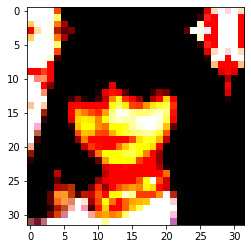

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img.permute(1,2,0))
print(label)

In [14]:
import torch
from torch.utils.data import random_split

In [15]:
random_seed=42
torch.manual_seed(random_seed)

In [16]:
#Splitting into Train and Validation Sets
val_size=5000
train_size=len(train)-val_size

train_ds,val_ds=random_split(train,[train_size,val_size])

In [17]:
len(train_ds),len(val_ds)

(45000, 5000)

In [18]:
#Loading the images in batches
from torch.utils.data.dataloader import DataLoader
batch_size=128

In [19]:
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl=DataLoader(val_ds,batch_size*2,num_workers=4,pin_memory=True)

In [20]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels,_ in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


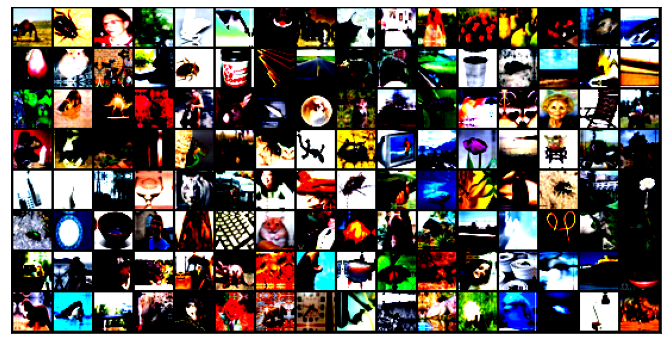

In [21]:
show_batch(train_dl)

In [22]:
#Building the model

In [23]:
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd

In [24]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels,_ = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels,_ = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [25]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [26]:
model = ResNet9(3, 100)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [27]:
def get_default_device():
    
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cuda')

In [29]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

In [30]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [31]:
model = to_device(ResNet9(3,100), device)

In [32]:
history=[evaluate(model, val_dl)]
history

[{'val_acc': 0.011914062313735485, 'val_loss': 4.6066484451293945}]

In [51]:
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [52]:

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                             grad_clip=grad_clip, 
                             weight_decay=weight_decay, 
                             opt_func=opt_func)

Epoch [0], last_lr: 0.00759, train_loss: 1.4882, val_loss: 2.5325, val_acc: 0.3607
Epoch [1], last_lr: 0.00950, train_loss: 1.9473, val_loss: 2.6184, val_acc: 0.3727
Epoch [2], last_lr: 0.00611, train_loss: 1.7668, val_loss: 2.0248, val_acc: 0.4639
Epoch [3], last_lr: 0.00188, train_loss: 1.4133, val_loss: 1.4205, val_acc: 0.6071
Epoch [4], last_lr: 0.00000, train_loss: 1.0351, val_loss: 1.2560, val_acc: 0.6434


In [53]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

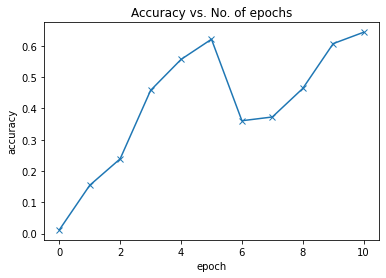

In [54]:
plot_accuracies(history)

In [55]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

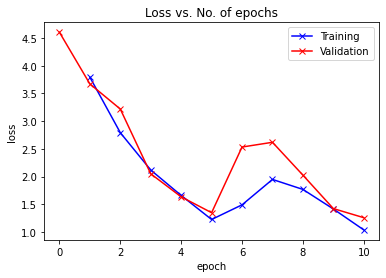

In [56]:
plot_losses(history)

In [57]:
test_dl=DataLoader(test,batch_size*2,num_workers=4,pin_memory=True)
test_dl = DeviceDataLoader(test_dl, device)

In [58]:
evaluate(model,test_dl)

{'val_acc': 0.6639648675918579, 'val_loss': 1.1835086345672607}

In [59]:
train_on_gpu=torch.cuda.is_available()

In [60]:
predicted_values=[]
model.eval()
for data,target,_ in test_dl:
  output=model(data)
  _,pred=torch.max(output,1)
  p=pred.cpu().numpy()
  t=p.tolist()
  predicted_values.append(t)
  

  

In [61]:
print(len(predicted_values))

40


In [62]:
flat_list = []
for sublist in predicted_values:
  for item in sublist:
    flat_list.append(item)

In [63]:
arr=np.arange(0,10000)

In [64]:
arr=pd.Series(arr)

In [65]:
arr1=arr.to_frame()

In [66]:
arr2=pd.DataFrame(flat_list)

In [67]:
df=pd.concat([arr1,arr2],ignore_index=True,axis=1)

In [68]:
df.to_csv("submission.csv",header=["Id","Category"],index=False)